# Fundamentos de Redes Neuronales en Finanzas — Bitcoin (BTC-USD)
Este notebook introduce los **fundamentos de redes neuronales artificiales (ANN)** aplicados a finanzas, mostrando paso a paso cómo se pueden usar para predecir la **volatilidad futura del Bitcoin (BTC‑USD)**.


## 1️⃣ Importar librerías y descargar datos

In [ ]:

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Descargar datos de Bitcoin desde 2018
data = yf.download("BTC-USD", start="2018-01-01", auto_adjust=True)
data["returns"] = np.log(data["Close"]).diff()
data["vol_real"] = data["returns"].rolling(21).std() * np.sqrt(252)
data["mom_21"] = data["Close"].pct_change(21)
data["vol_5"] = data["returns"].rolling(5).std() * np.sqrt(252)
data["vol_21"] = data["returns"].rolling(21).std() * np.sqrt(252)
data["target"] = data["returns"].rolling(21).std().shift(-21) * np.sqrt(252)
data.dropna(inplace=True)

data.tail()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,returns,vol_real,mom_21,vol_5,vol_21,target
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD,,,,,,
Date,,,,,,,,,,,
2025-09-29,114400.382812,114473.570312,111589.953125,112117.875000,60000147466,0.020111,0.228507,0.020781,0.388002,0.228507,0.398858
2025-09-30,114056.085938,114836.617188,112740.562500,114396.523438,58986330258,-0.003014,0.228009,0.022644,0.183034,0.228009,0.403532
2025-10-01,118648.929688,118648.929688,113981.398438,114057.593750,71328680132,0.039479,0.255187,0.041188,0.278404,0.255187,0.373822
2025-10-02,120681.257812,121086.406250,118383.156250,118652.382812,71415163912,0.016984,0.257438,0.044791,0.240524,0.257438,0.377742
2025-10-03,122266.531250,123944.703125,119344.312500,120656.984375,83941392228,0.013051,0.260066,0.053100,0.242134,0.260066,0.373738


## 2️⃣ Preparación de datos

In [ ]:

X = data[["vol_5", "vol_21", "mom_21"]]
y = data["target"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

X_train.shape, X_test.shape


((2249, 3), (563, 3))

## 3️⃣ Construir y entrenar la red neuronal

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


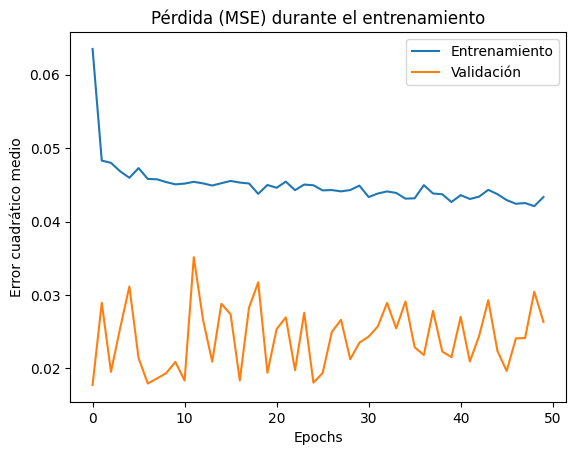

In [ ]:

model = Sequential([
    Dense(16, activation='relu', input_dim=X_train.shape[1]),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, validation_data=(X_test, y_test))

# Graficar el error durante el entrenamiento
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.legend()
plt.title('Pérdida (MSE) durante el entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Error cuadrático medio')
plt.show()


## 4️⃣ Evaluación del modelo

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


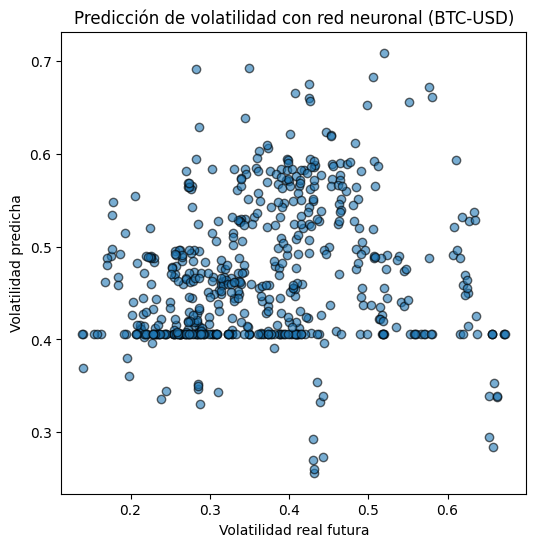

MAE: 0.1420 | RMSE: 0.1622


In [ ]:

y_pred = model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.xlabel("Volatilidad real futura")
plt.ylabel("Volatilidad predicha")
plt.title("Predicción de volatilidad con red neuronal (BTC-USD)")
plt.show()

# Calcular métricas de error
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")


## 5️⃣ Interpretación de resultados
- La red neuronal aprende relaciones **no lineales** entre la volatilidad pasada y la futura.  
- Las capas ocultas actúan como **extractores automáticos de patrones** de mercado.  
- Si el error de validación converge, el modelo logra generalizar correctamente.  
- Puedes modificar:
  - Número de neuronas o capas.
  - Función de activación (`relu`, `tanh`, `sigmoid`).
  - Tasa de aprendizaje (`learning_rate`).
  - Número de épocas (`epochs`).


## 6️⃣ Próximos pasos
- Implementar una red **LSTM** para capturar memoria temporal.  
- Comparar la predicción de volatilidad con un modelo **GARCH(1,1)** clásico.  
- Usar la volatilidad predicha como entrada en **Black–Scholes** para calcular precios de opciones sintéticas.  


# Con LSTM

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
!pip install tensorflow

In [ ]:
# 1️⃣ Descargar datos
data = yf.download("BTC-USD", start="2024-03-25", auto_adjust=True)
data["returns"] = np.log(data["Close"]).diff()
data["vol_real"] = data["returns"].rolling(21).std() * np.sqrt(365)
data.dropna(inplace=True)


[*********************100%***********************]  1 of 1 completed


In [ ]:
# 2️⃣ Construir características y objetivo
data["target"] = data["vol_real"].shift(-21)
data.dropna(inplace=True)

# Escalar
scaler = StandardScaler()
scaled = scaler.fit_transform(data[["vol_real", "returns"]])
scaled_df = pd.DataFrame(scaled, columns=["vol_real", "returns"], index=data.index)
scaled_df["target"] = data["target"].values

In [ ]:
# 3️⃣ Crear secuencias para LSTM (ventana = 30 días)
def create_sequences(df, window=30):
    X, y = [], []
    for i in range(len(df) - window):
        X.append(df[["vol_real", "returns"]].iloc[i:i+window].values)
        y.append(df["target"].iloc[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_df, window=30)

# Dividir 80/20 sin mezclar
split = int(len(X)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [ ]:
# 4️⃣ Modelo LSTM
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
history = model.fit(X_train, y_train, epochs=60, batch_size=16,
                    validation_data=(X_test, y_test), verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 5️⃣ Evaluación
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
MAE: 0.0980 | RMSE: 0.1224


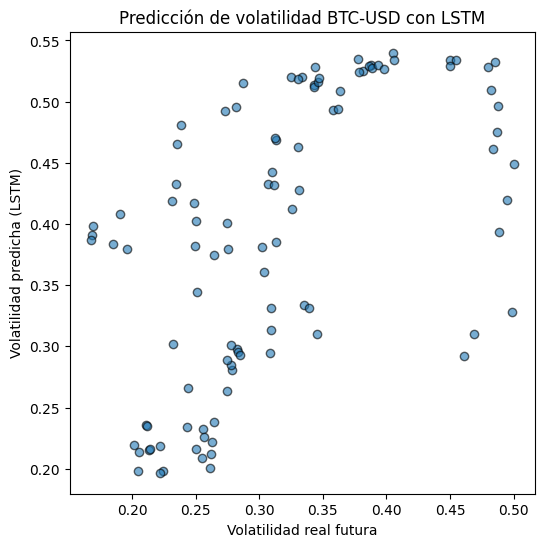

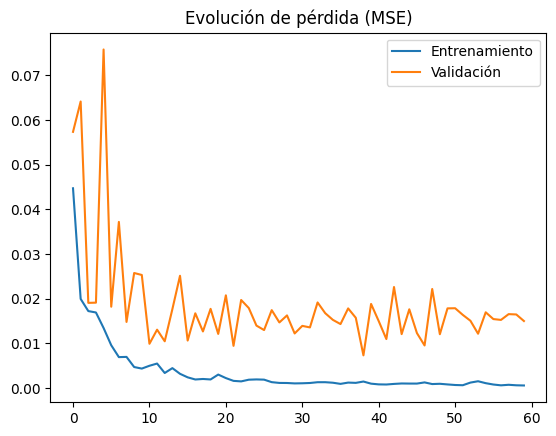

In [ ]:
# 6️⃣ Visualización
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolor='k')
plt.xlabel("Volatilidad real futura")
plt.ylabel("Volatilidad predicha (LSTM)")
plt.title("Predicción de volatilidad BTC-USD con LSTM")
plt.show()

plt.plot(history.history["loss"], label="Entrenamiento")
plt.plot(history.history["val_loss"], label="Validación")
plt.legend(); plt.title("Evolución de pérdida (MSE)"); plt.show()